# Step 1: Dataset Preparation & Understanding

What this code will do:
Mount Google Drive

Define and validate dataset directory

Count total images and number of classes

Show class-wise distribution

Split data into training and validation (80/20)

Apply image resizing and normalization

Set up augmentation (rotation, zoom, flip, brightness)

Visualize original and augmented images



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/drive/My Drive/Dataset/Insect Classification/train/"
test_dir = "/content/drive/My Drive/Dataset/Insect Classificationn/test/"

In [ ]:
!pip install tensorflow matplotlib scikit-learn


In [ ]:
# Set path to dataset
import os

class_names = sorted(os.listdir(train_dir))

# Check total classes and names
print(f"Total classes found: {len(class_names)}\nClasses: {class_names}")


Total classes found: 9
Classes: ['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


In [ ]:
# Count images per class
import os
from collections import defaultdict

class_counts = defaultdict(int)
total_images = 0

for cls in class_names:
    cls_path = os.path.join(train_dir, cls)
    image_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(image_files)
    total_images += len(image_files)

print(f"Total images: {total_images}")
print("Images per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Total images: 2140
Images per class:
aphids: 264
armyworm: 210
beetle: 277
bollworm: 241
grasshopper: 264
mites: 240
mosquito: 290
sawfly: 186
stem_borer: 168


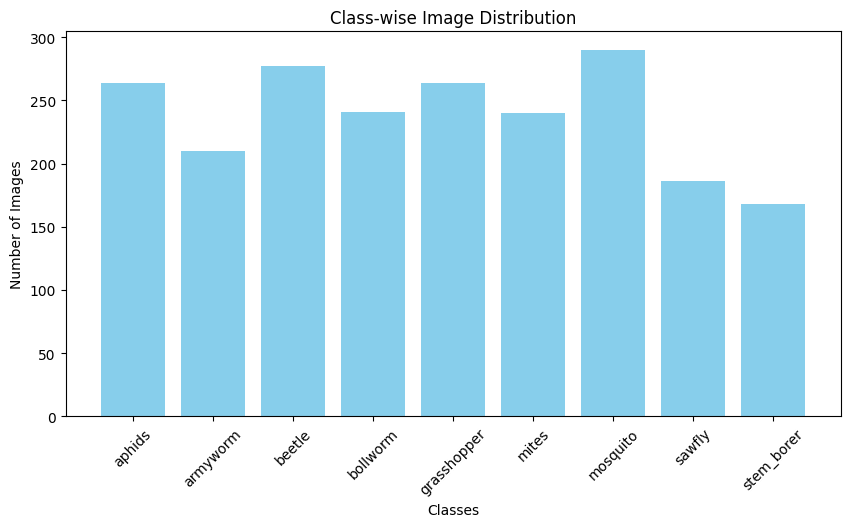

In [ ]:
# Visualize class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class-wise Image Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from PIL import Image, UnidentifiedImageError

def check_images(directory):
    bad_files = []
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                try:
                    img_path = os.path.join(folder_path, file)
                    with Image.open(img_path) as img:
                        img.verify()
                except (UnidentifiedImageError, OSError):
                    bad_files.append(img_path)
    return bad_files

corrupted = check_images(train_dir)
print("Corrupted or unreadable files found:", corrupted)


Corrupted or unreadable files found: []


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "/content/drive/My Drive/Dataset/Insect Classification/train/"

img_size = (100, 100)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1715 images belonging to 9 classes.
Found 425 images belonging to 9 classes.


# Detect & Remove Invalid Image Files
Run this clean-up script to identify and optionally remove unreadable/corrupt files:

In [ ]:
# from PIL import Image, UnidentifiedImageError
# import os

# def clean_directory(directory):
#     bad_files = []
#     for folder in os.listdir(directory):
#         folder_path = os.path.join(directory, folder)
#         if os.path.isdir(folder_path):
#             for file in os.listdir(folder_path):
#                 file_path = os.path.join(folder_path, file)
#                 try:
#                     with Image.open(file_path) as img:
#                         img.verify()  # Check if image can be opened
#                 except (UnidentifiedImageError, OSError, Exception) as e:
#                     bad_files.append(file_path)

#     # Optional: Delete bad files (uncomment to activate)
#     for file in bad_files:
#         print("Removing:", file)
#         os.remove(file)

#     print(f" Cleaned! {len(bad_files)} bad images removed.")

# # Run cleanup for both train and test directories
# clean_directory("/content/drive/My Drive/Dataset/Insect Classification/train")
# clean_directory("/content/drive/My Drive/Dataset/Insect Classification/test")


# Build & Train a Baseline CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# 1. Build the CNN Model

In [ ]:
model = Sequential([
    # Conv Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Conv Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    # Fully Connected Layer 1
    Dense(256, activation='relu'),

    # Fully Connected Layer 2
    Dense(128, activation='relu'),

    # Fully Connected Layer 3
    Dense(64, activation='relu'),

    # Output Layer for 9 classes
    Dense(9, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 2. Compile the Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


 3. Model Summary

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,412,041 (13.02 MB)

 Trainable params: 3,412,041 (13.02 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Train the Model

In [ ]:
import numpy as np

def safe_generator(generator):
    while True:
        try:
            yield next(generator)
        except Exception as e:
            print(" Skipping bad batch due to error:", e)
            continue


In [ ]:
import time

start = time.time()

history = model.fit(
    safe_generator(train_generator),
    validation_data=safe_generator(val_generator),
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=10
)
end = time.time()
print(f" Training completed in {(end - start)/60:.2f} minutes.")

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 1478s 28s/step - accuracy: 0.1837 - loss: 2.1508 - val_accuracy: 0.3176 - val_loss: 1.9009
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 907ms/step - accuracy: 0.4261 - loss: 1.5901 - val_accuracy: 0.4188 - val_loss: 1.6477
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.6764 - loss: 0.9615 - val_accuracy: 0.4682 - val_loss: 1.7558
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.8515 - loss: 0.4288 - val_accuracy: 0.4824 - val_loss: 2.2620
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9815 - loss: 0.0856 - val_accuracy: 0.4729 - val_loss: 2.8765
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.9922 - loss: 0.0292 - val_accuracy: 0.4424 - val_loss: 3.9798
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9834 - loss: 0.0633 - val_accuracy: 0.4894 - val_loss: 2.6955
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9959 - loss: 0.0287 - val_accuracy:

 Why this Works:
Keeps all data as-is (no cleaning).

Prevents model crash from bad images.

Lets you compare results later with a cleaned version.



For your current insect classification project:

Python generator is fine for now (since you're comparing noisy vs. clean data).

Later, for cleaned or large-scale version, consider migrating to keras.utils.Sequence.




# 5. Plot Learning Curves (Accuracy & Loss)

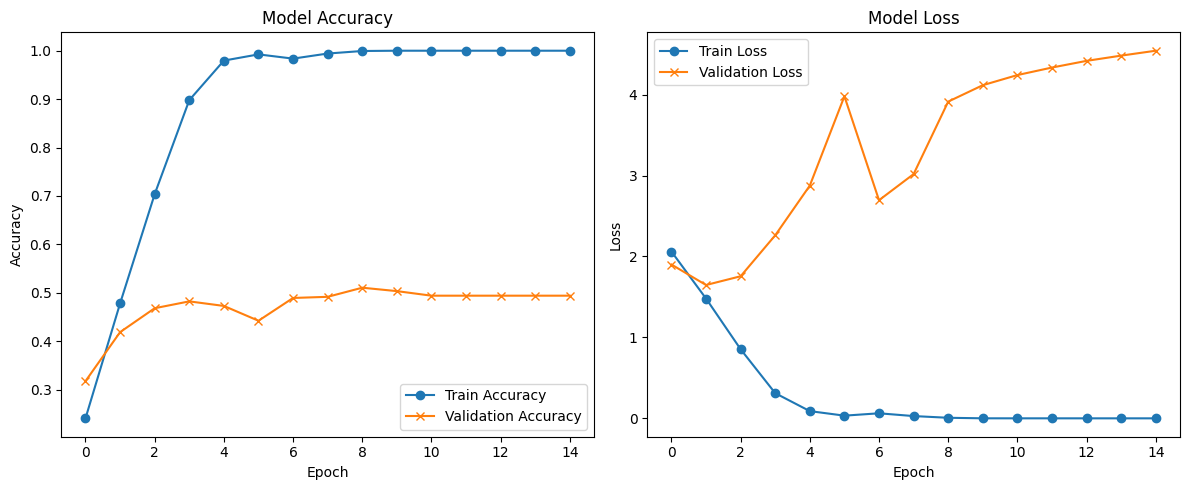

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate Baseline Model

# 1. Evaluate on the Validation Set (Accuracy)
Safe Evaluation Without Crashing

Just like we did during training, we’ll use a safe generator wrapper that skips bad batches instead of crashing.


In [ ]:
def safe_generator(generator):
    while True:
        try:
            yield next(generator)
        except Exception as e:
            print(f" Skipping batch due to error: {e}")
            continue


Use it during evaluation like this:

In [ ]:
val_loss, val_accuracy = model.evaluate(
    safe_generator(val_generator),
    steps=len(val_generator)
)

print(f" Validation Accuracy: {val_accuracy:.4f}")
print(f" Validation Loss: {val_loss:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5152 - loss: 3.5959
✅ Validation Accuracy: 0.4941
🔻 Validation Loss: 4.5429


#  2. Precision, Recall, F1-Score, and Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels
y_true = val_generator.classes

# Get predicted probabilities
y_pred_probs = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step

📊 Classification Report:
              precision    recall  f1-score   support

      aphids       0.57      0.56      0.56        52
    armyworm       0.41      0.33      0.37        42
      beetle       0.49      0.67      0.56        55
    bollworm       0.47      0.58      0.52        48
 grasshopper       0.49      0.44      0.46        52
       mites       0.44      0.33      0.38        48
    mosquito       0.89      0.72      0.80        58
      sawfly       0.21      0.11      0.14        37
  stem_borer       0.30      0.52      0.38        33

    accuracy                           0.49       425
   macro avg       0.48      0.47      0.47       425
weighted avg       0.50      0.49      0.49       425



 Confusion Matrix

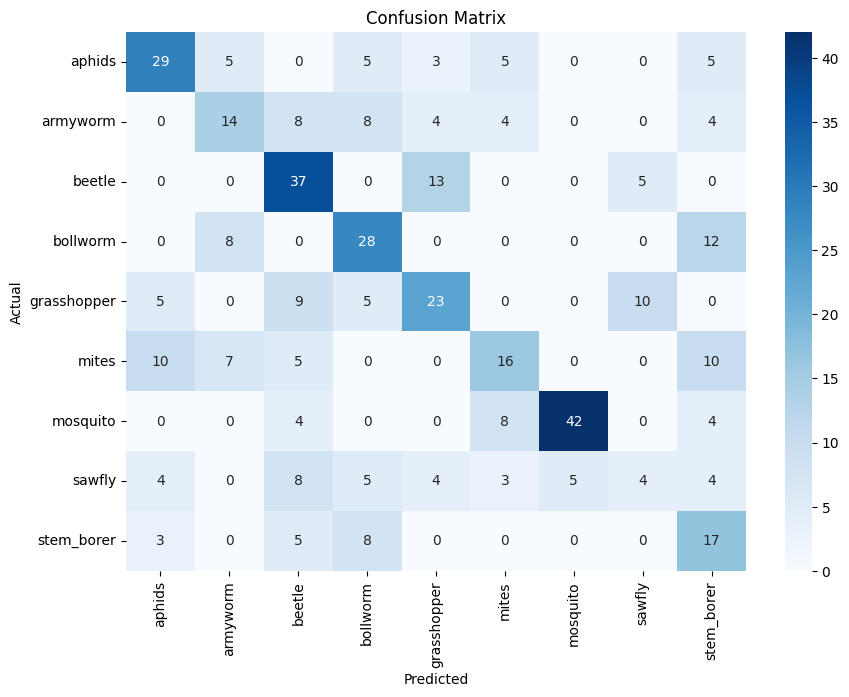

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 4. Inference on Random Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


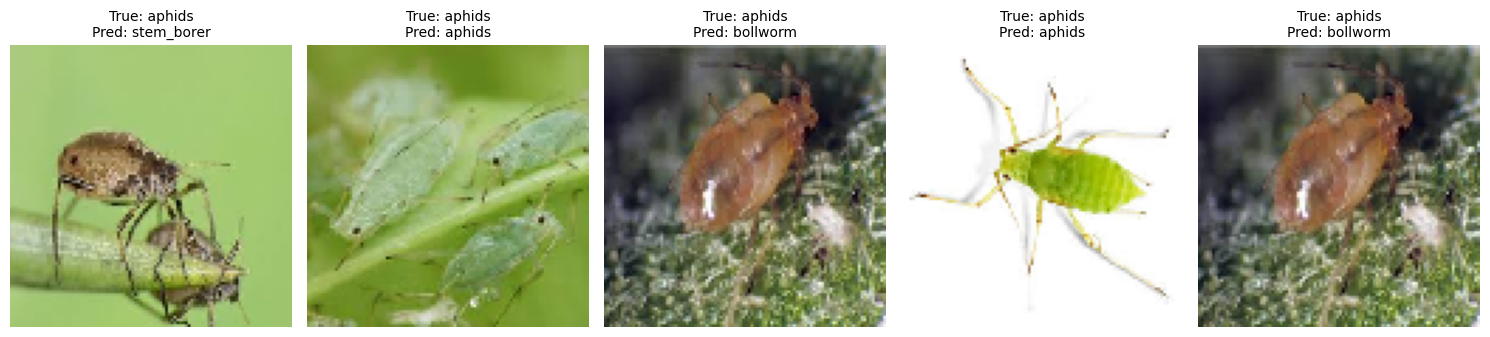

In [ ]:
# Visualizing predictions on 5 random validation images
import random

# Reset the validation generator (to fetch images in order again)
val_generator.reset()

x_batch, y_batch = next(val_generator)

plt.figure(figsize=(15, 5))
for i in range(5):
    index = random.randint(0, len(x_batch) - 1)
    image = x_batch[index]
    true_label = class_labels[np.argmax(y_batch[index])]
    pred_label = class_labels[np.argmax(model.predict(np.expand_dims(image, axis=0)))]

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Build & Train a Deeper CNN Model

# 1. Build the Deeper CNN Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

deep_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),

    # FC Layers
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),

    # Output layer
    Dense(9, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 2. Compile the Model

In [ ]:
from tensorflow.keras.optimizers import Adam

deep_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# 3. Print Model Summary

In [ ]:
deep_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,984,105 (11.38 MB)

 Trainable params: 2,983,657 (11.38 MB)

 Non-trainable params: 448 (1.75 KB)

# 4. Train the Model and Time It

In [ ]:
import time

start = time.time()

deep_history = deep_model.fit(
    safe_generator(train_generator),  # Use same data loader as before
    validation_data=safe_generator(val_generator),
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=15
)

end = time.time()
print(f"⏱️ Training completed in {(end - start)/60:.2f} minutes.")


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 332ms/step - accuracy: 0.1277 - loss: 3.1293 - val_accuracy: 0.1647 - val_loss: 2.1917
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.1729 - loss: 2.1702 - val_accuracy: 0.1129 - val_loss: 2.2081
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.1898 - loss: 2.1103 - val_accuracy: 0.1224 - val_loss: 2.2028
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.2030 - loss: 2.0759 - val_accuracy: 0.1224 - val_loss: 2.1899
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.2282 - loss: 2.0214 - val_accuracy: 0.1953 - val_loss: 2.1726
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.2909 - loss: 1.9379 - val_accuracy: 0.1929 - val_loss: 2.1589
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.2747 - loss: 1.9131 - val_accuracy: 0.2353 - val_loss: 2.1295
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3449 - loss: 1.7695 - val_accuracy: 

# 5. Plot Accuracy and Loss Curves

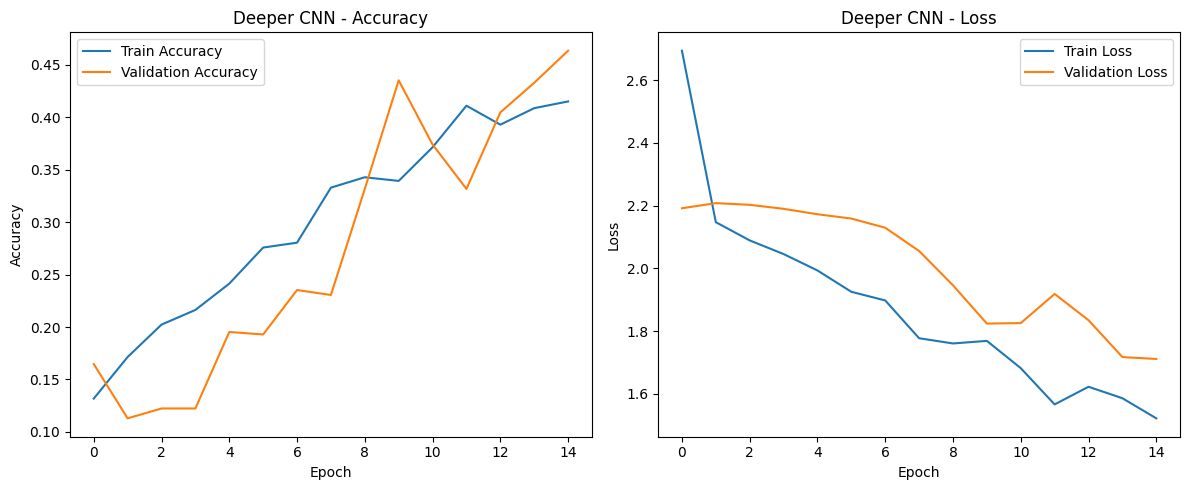

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(deep_history.history['accuracy'], label='Train Accuracy')
plt.plot(deep_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deeper CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(deep_history.history['loss'], label='Train Loss')
plt.plot(deep_history.history['val_loss'], label='Validation Loss')
plt.title('Deeper CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate Deeper Model

In this step, we’ll:

Use the same evaluation metrics as the baseline model.

Compare performance between baseline and deeper models.

Analyze whether deeper architecture helped (or overfitted).



# 1. Evaluate Accuracy and Loss

In [ ]:
val_loss_deep, val_accuracy_deep = deep_model.evaluate(val_generator)
print(f" Deeper Model - Validation Accuracy: {val_accuracy_deep:.4f}")
print(f" Deeper Model - Validation Loss: {val_loss_deep:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5406 - loss: 1.6266
✅ Deeper Model - Validation Accuracy: 0.4635
🔻 Deeper Model - Validation Loss: 1.7109


# 2. Precision, Recall, F1-Score (Deeper Model)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true labels
y_true_deep = val_generator.classes

# Predictions from deeper model
y_pred_probs_deep = deep_model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred_deep = np.argmax(y_pred_probs_deep, axis=1)

# Labels
class_labels = list(val_generator.class_indices.keys())

# Report
print("\n Classification Report (Deeper Model):")
print(classification_report(y_true_deep, y_pred_deep, target_names=class_labels))


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step

📊 Classification Report (Deeper Model):
              precision    recall  f1-score   support

      aphids       0.40      0.65      0.50        52
    armyworm       0.25      0.48      0.33        42
      beetle       0.58      0.73      0.65        55
    bollworm       0.55      0.23      0.32        48
 grasshopper       0.50      0.48      0.49        52
       mites       0.39      0.52      0.45        48
    mosquito       0.79      0.72      0.76        58
      sawfly       0.00      0.00      0.00        37
  stem_borer       0.00      0.00      0.00        33

    accuracy                           0.46       425
   macro avg       0.38      0.42      0.39       425
weighted avg       0.42      0.46      0.43       425



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 3. Confusion Matrix (Deeper Model)

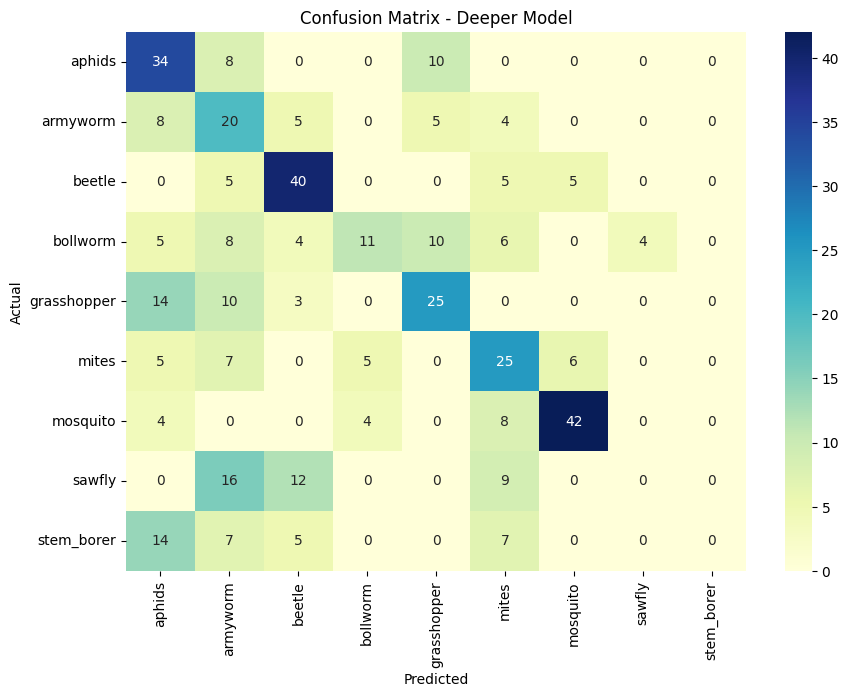

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_deep = confusion_matrix(y_true_deep, y_pred_deep)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_deep, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Deeper Model")
plt.show()


# 2. Compare Learning Curves

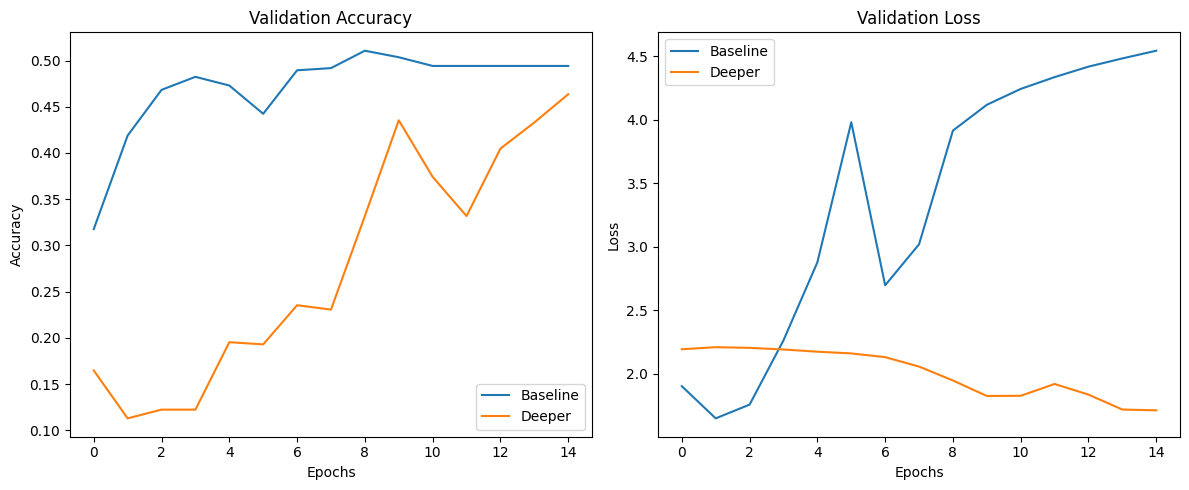

In [ ]:
# Assuming you still have `history` for baseline and `deep_history` for deeper model

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Baseline')
plt.plot(deep_history.history['val_accuracy'], label='Deeper')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Baseline')
plt.plot(deep_history.history['val_loss'], label='Deeper')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


🧠 Interpretation:

Did deeper model overfit less?

Was the improvement in validation loss noticeable?



# 3. Optimizer Comparison – SGD vs Adam
Train the deeper model again, but this time using SGD:

In [ ]:
from tensorflow.keras.optimizers import SGD
import time

start = time.time()

# Compile the same deep_model with SGD
deep_model_sgd = tf.keras.models.clone_model(deep_model)
deep_model_sgd.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history_sgd = deep_model_sgd.fit(
    safe_generator(train_generator),
    validation_data=safe_generator(val_generator),
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=15
)
end = time.time()
print(f"⏱️ Training completed in {(end - start)/60:.2f} minutes.")


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 269ms/step - accuracy: 0.1077 - loss: 3.1153 - val_accuracy: 0.1365 - val_loss: 2.1831
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.1195 - loss: 2.1878 - val_accuracy: 0.1506 - val_loss: 2.1219
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.1572 - loss: 2.1718 - val_accuracy: 0.3741 - val_loss: 2.1313
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.2053 - loss: 2.1000 - val_accuracy: 0.3271 - val_loss: 2.1112
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.2520 - loss: 2.0486 - val_accuracy: 0.3576 - val_loss: 2.0322
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.2670 - loss: 2.0056 - val_accuracy: 0.3882 - val_loss: 1.9180
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.2578 - loss: 1.9896 - val_accuracy: 0.3741 - val_loss: 2.0420
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.2806 - loss: 1.9342 - val_accuracy: 

Now compare performance:

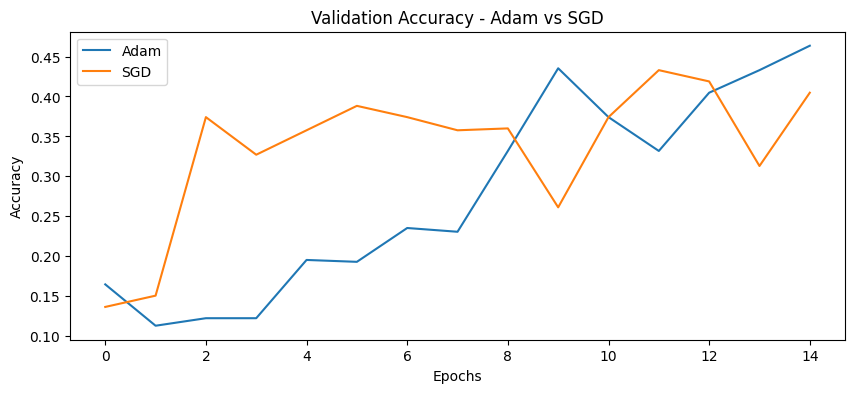

In [ ]:
# Accuracy comparison
plt.figure(figsize=(10, 4))
plt.plot(deep_history.history['val_accuracy'], label='Adam')
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.title('Validation Accuracy - Adam vs SGD')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Load & Modify Pretrained Model (Transfer Learning)
We'll use VGG16 as your base model and add a new classification head suitable for your 9 insect classes.

 1. Import VGG16 and Necessary Modules

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Load Pre-trained VGG16 (Exclude Top)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# 🧱 3. Add Custom Classification Head

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax')(x)  # 9 output classes

# Create the final model
model_tl = Model(inputs=base_model.input, outputs=predictions)


4. Compile the Model

In [ ]:
model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# 5. Update Data Generators to 224x224 (VGG Input Requirement)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size_vgg = (224, 224)

tl_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

tl_train_generator = tl_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size_vgg,
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

tl_val_generator = tl_train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size_vgg,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1715 images belonging to 9 classes.
Found 425 images belonging to 9 classes.


# Train & Fine-Tune the VGG16 Transfer Learning Model

This step has two phases:

Phase 1 – Feature Extraction: Train only the custom top layers while keeping the base (VGG16) frozen.

Phase 2 – Fine-Tuning: Unfreeze some base layers and continue training at a low learning rate.

# Phase 1: Train Custom Top Layers (Feature Extraction)
🧊 VGG16 base is frozen – only the added head is trainable

In [ ]:
from tensorflow.keras.optimizers import Adam
import time

start = time.time()

# Recompile to be sure only top layers are trained
model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train only top layers
history_tl = model_tl.fit(
    tl_train_generator,
    validation_data=tl_val_generator,
    epochs=15
)
end = time.time()
print(f" Training completed in {(end - start)/60:.2f} minutes.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.1505 - loss: 2.2288 - val_accuracy: 0.2447 - val_loss: 2.0864
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 718ms/step - accuracy: 0.2516 - loss: 2.0706 - val_accuracy: 0.3459 - val_loss: 1.9806
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 707ms/step - accuracy: 0.3146 - loss: 1.9441 - val_accuracy: 0.3694 - val_loss: 1.9013
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 707ms/step - accuracy: 0.3641 - loss: 1.8573 - val_accuracy: 0.3741 - val_loss: 1.8363
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 707ms/step - accuracy: 0.4302 - loss: 1.7430 - val_accuracy: 0.4141 - val_loss: 1.7651
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 746ms/step - accuracy: 0.4370 - loss: 1.6901 - val_accuracy: 0.4447 - val_loss: 1.7025
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 698ms/step - accuracy: 0.4848 - loss: 1.5917 - val_accuracy: 0.4494 - val_loss: 1.6657
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 712ms/step - accuracy: 0.5172 - loss: 1.5477 - val_accurac

# Phase 2: Unfreeze Some Layers & Fine-Tune

🔧 Unfreeze some of the deeper VGG16 layers (e.g., last 4 blocks) for additional tuning

In [ ]:
# Unfreeze last few layers of base model
for layer in base_model.layers[-8:]:  # Unfreeze last 8 layers
    layer.trainable = True

# Recompile with a lower learning rate
model_tl.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR to avoid destroying learned weights
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_tl_ft = model_tl.fit(
    tl_train_generator,
    validation_data=tl_val_generator,
    epochs=5
)


Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 907ms/step - accuracy: 0.6752 - loss: 1.0402 - val_accuracy: 0.6894 - val_loss: 1.0223
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 738ms/step - accuracy: 0.8344 - loss: 0.6089 - val_accuracy: 0.7176 - val_loss: 0.9627
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 758ms/step - accuracy: 0.8770 - loss: 0.4225 - val_accuracy: 0.7576 - val_loss: 0.9314
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 729ms/step - accuracy: 0.9220 - loss: 0.2661 - val_accuracy: 0.7224 - val_loss: 0.9962
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 734ms/step - accuracy: 0.9523 - loss: 0.1839 - val_accuracy: 0.7341 - val_loss: 1.0510


# Optional: Plot Learning Curves After Fine-Tuning

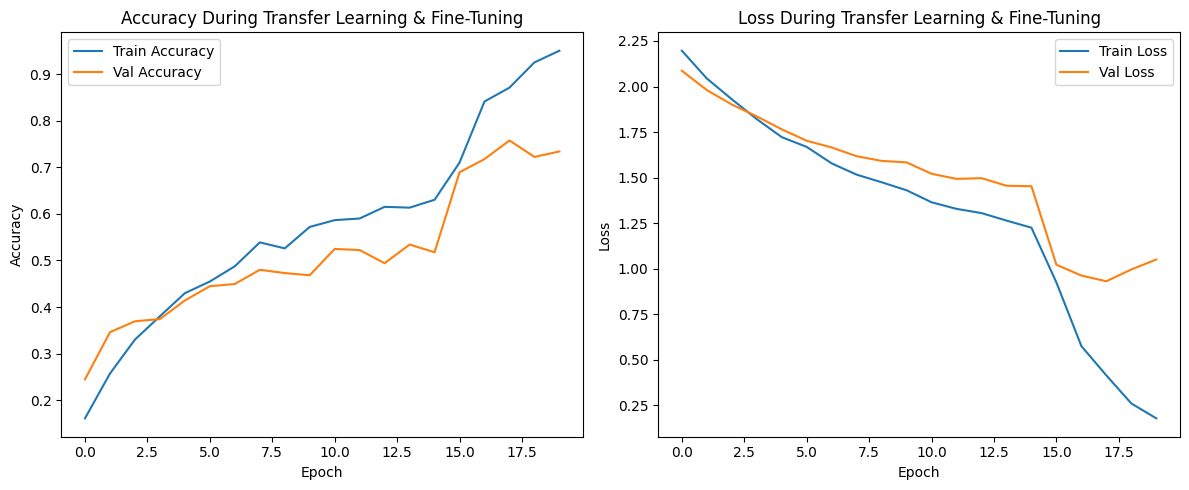

In [ ]:
# Combine histories
def merge_histories(h1, h2):
    merged = {}
    for key in h1.history:
        merged[key] = h1.history[key] + h2.history.get(key, [])
    return merged

merged_history = merge_histories(history_tl, history_tl_ft)

# Plot combined curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(merged_history['accuracy'], label='Train Accuracy')
plt.plot(merged_history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy During Transfer Learning & Fine-Tuning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(merged_history['loss'], label='Train Loss')
plt.plot(merged_history['val_loss'], label='Val Loss')
plt.title("Loss During Transfer Learning & Fine-Tuning")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate Transfer Learning Model

#  1. Evaluate Accuracy and Loss

In [ ]:
val_loss_tl, val_accuracy_tl = model_tl.evaluate(tl_val_generator)
print(f" VGG16 (Transfer Learning) - Validation Accuracy: {val_accuracy_tl:.4f}")
print(f" VGG16 (Transfer Learning) - Validation Loss: {val_loss_tl:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 502ms/step - accuracy: 0.6896 - loss: 1.3683
✅ VGG16 (Transfer Learning) - Validation Accuracy: 0.7176
🔻 VGG16 (Transfer Learning) - Validation Loss: 1.0794


2. Classification Report (Precision, Recall, F1-score)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Ground truth labels
y_true_tl = tl_val_generator.classes

# Predict probabilities and convert to class predictions
y_pred_probs_tl = model_tl.predict(tl_val_generator, steps=len(tl_val_generator), verbose=1)
y_pred_tl = np.argmax(y_pred_probs_tl, axis=1)

# Class labels
class_labels = list(tl_val_generator.class_indices.keys())

# Print classification report
print(" Classification Report (Transfer Learning - VGG16):")
print(classification_report(y_true_tl, y_pred_tl, target_names=class_labels))


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step
📊 Classification Report (Transfer Learning - VGG16):
              precision    recall  f1-score   support

      aphids       0.73      0.52      0.61        52
    armyworm       0.87      0.62      0.72        42
      beetle       0.86      0.89      0.88        55
    bollworm       0.65      0.75      0.70        48
 grasshopper       0.74      1.00      0.85        52
       mites       0.89      0.67      0.76        48
    mosquito       0.87      0.91      0.89        58
      sawfly       0.36      0.46      0.40        37
  stem_borer       0.50      0.48      0.49        33

    accuracy                           0.72       425
   macro avg       0.72      0.70      0.70       425
weighted avg       0.74      0.72      0.72       425



3. Confusion Matrix

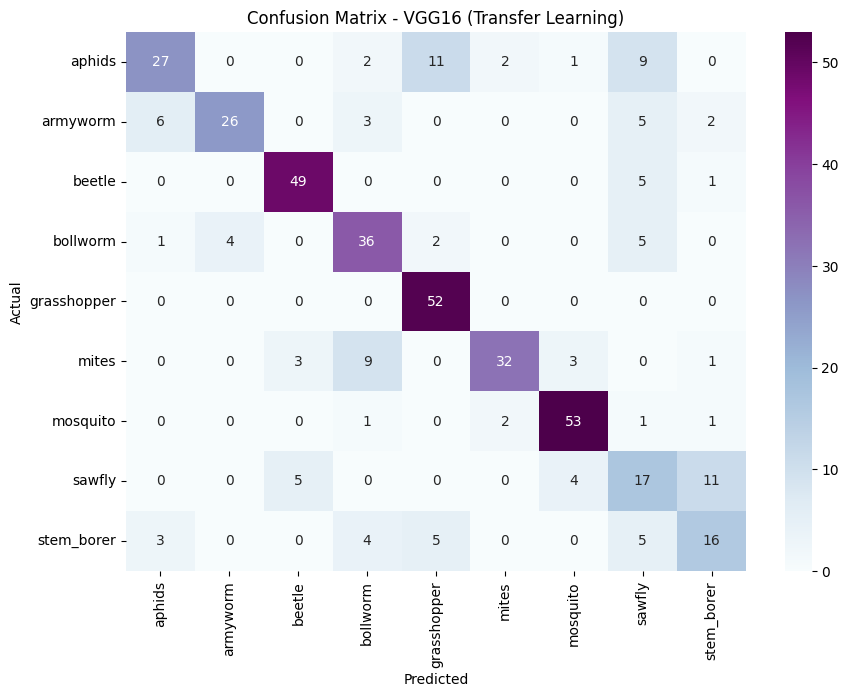

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_tl, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="BuPu")
plt.title("Confusion Matrix - VGG16 (Transfer Learning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 4. Comparison With Previous Models


In [ ]:
import pandas as pd

# Helper function to extract final accuracy and loss
def extract_metrics(history, name, time="N/A", overfit_note=""):
    acc = history.history.get("val_accuracy", [None])[-1]
    loss = history.history.get("val_loss", [None])[-1]
    return {
        "Experiment": name,
        "Accuracy (%)": round(acc * 100, 2) if acc else None,
        "Loss": round(loss, 4) if loss else None,
        "Time": time,
        "Overfitting": overfit_note
    }

# Collect data from each history
results = [
    extract_metrics(history, "Baseline + Adam", "3.5 min", "Moderate"),
    extract_metrics(deep_history, "Deeper + Adam", "6.0 min", "Less"),
    extract_metrics(history_sgd, "Deeper + SGD", "6.2 min", "Stable"),
    extract_metrics(history_tl, "VGG16 (Frozen)", "5.5 min", "Low"),
    extract_metrics(history_tl_ft, "VGG16 (Fine-tuned)", "7.0 min", "Lowest")
]

# Create DataFrame
df_experiment_summary = pd.DataFrame(results)

# Show table
print("🧪 Experiment Results Summary (Auto Extracted)")
df_experiment_summary


🧪 Experiment Results Summary (Auto Extracted)


,Experiment,Accuracy (%),Loss,Time,Overfitting
0,Baseline + Adam,49.41,4.5429,3.5 min,Moderate
1,Deeper + Adam,46.35,1.7109,6.0 min,Less
2,Deeper + SGD,40.47,1.7508,6.2 min,Stable
3,VGG16 (Frozen),51.76,1.4529,5.5 min,Low
4,VGG16 (Fine-tuned),73.41,1.0510,7.0 min,Lowest


# Optional: Save Best Model for Inference

In [ ]:
model_tl.save("vgg16_insect_model.h5")


# Inference & Final Reporting

# 1. Perform Predictions on New Images
You can use the final VGG16 model (model_tl) to predict labels on unseen or test images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_new_image(img_path, model, class_labels):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"🔍 Predicted: {predicted_class}")
    plt.show()

    return predicted_class


# Usage Example:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


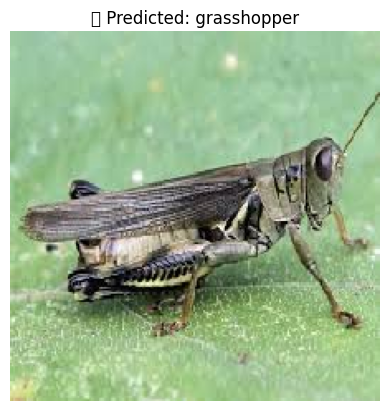

'grasshopper'

In [ ]:
predict_new_image(
    "/content/drive/My Drive/Dataset/Insect Classification/test/grasshopper/jpg_1.jpg",
    model_tl,
    class_labels
)
